In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Load data
Initial info about the ERA5-Land data and corresponding plots are shown below.

In [2]:
dset = xr.open_dataset('/fs/nexus-scratch/mattchan/datasets/era5-land/test.grib2', engine='cfgrib')
dset

Ignoring index file '/fs/nexus-scratch/mattchan/datasets/era5-land/test.grib2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (latitude: 551, longitude: 561)
Coordinates:
    number      int64 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 65.0 64.9 64.8 64.7 ... 10.3 10.2 10.1 10.0
  * longitude   (longitude) float64 -126.0 -125.9 -125.8 ... -70.2 -70.1 -70.0
    valid_time  datetime64[ns] ...
Data variables:
    t2m         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-07-16T18:22 GRIB to CDM+CF via cfgrib-0.9.1...

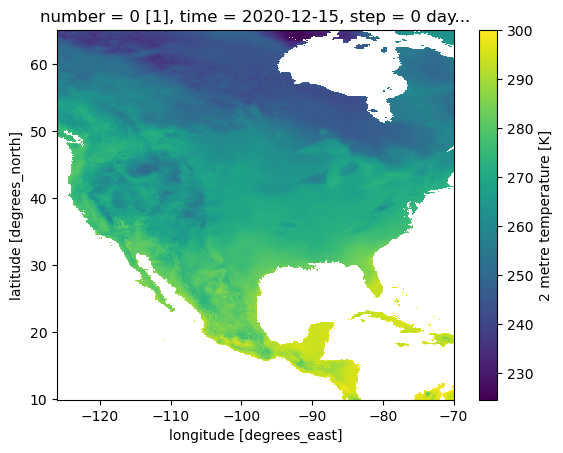

In [3]:
dset['t2m'].plot()

# NN preprocessing
Before we train a network on the data, we need to clean it up a bit. We define a function that converts the data units from Kelvin to Fahrenheit.


In [4]:
import torchvision.transforms as T

class KelvinToFahrenheit(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        return (sample - 273.15) * (9/5) + 32

We show the areas where the data is NaN in the plot below. ERA5-Land has no ocean data available, so those areas are NaN. (Note: small regions near the ocean/land border are also NaN)

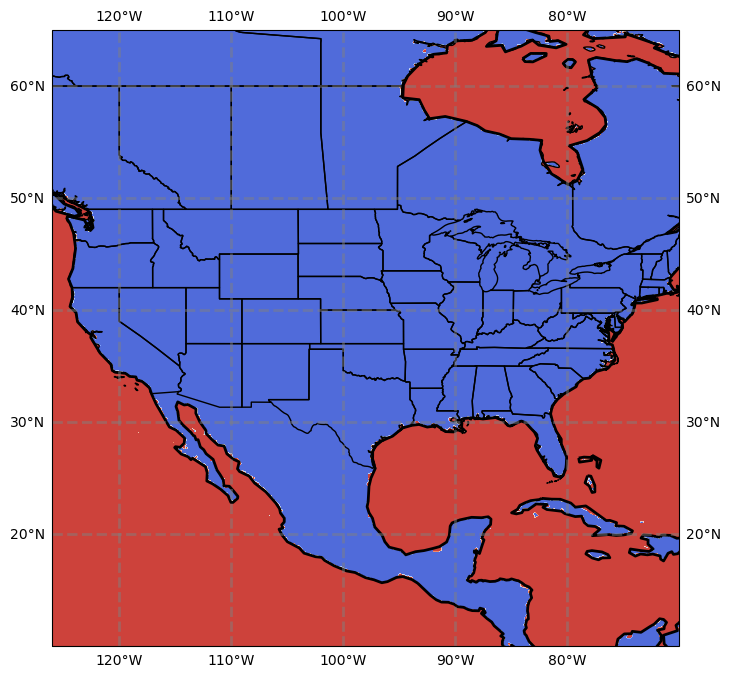

In [5]:
import cartopy.feature as cfeature
import numpy as np

lats, lons = dset.latitude, dset.longitude
temps = dset['t2m'].values
nans = np.where(np.isnan(temps), 1, 0)

fig, ax = plt.subplots(figsize=(11, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines(linewidth=2)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.contourf(lons, lats, nans, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.add_feature(cfeature.STATES.with_scale('50m'), zorder=1, linewidth=1, edgecolor='black')

The following preprocessing steps are applied to data:
1. Remove NaNs and fill with -inf
2. Convert data to Tensor
3. Center crop to 550x550 resolution
4. Convert the data from Kelvin to Fahrenheit 

In [6]:
temps = np.nan_to_num(temps, nan=-np.inf)
assert np.any(np.isnan(temps)) == False
print("In shape:", temps.shape)

tfm = T.Compose([T.ToTensor(), T.CenterCrop([550, 550]), KelvinToFahrenheit()])
temps = tfm(temps)
print("Out shape:", temps.shape)

In shape: (551, 561)
Out shape: torch.Size([1, 550, 550])


We also crop the latitude and longitude to the same size as the data.

In [7]:
def center_crop_1d(sample, output_size):
    size = len(sample)
    assert output_size <= size

    crop_top = int(round((size - output_size) / 2.0))
    return sample[crop_top:crop_top+output_size]

lats = center_crop_1d(dset.latitude.values, 550)
lons = center_crop_1d(dset.longitude.values, 550)

The temperature map can be visualized on a projected map (with statelines drawn in).

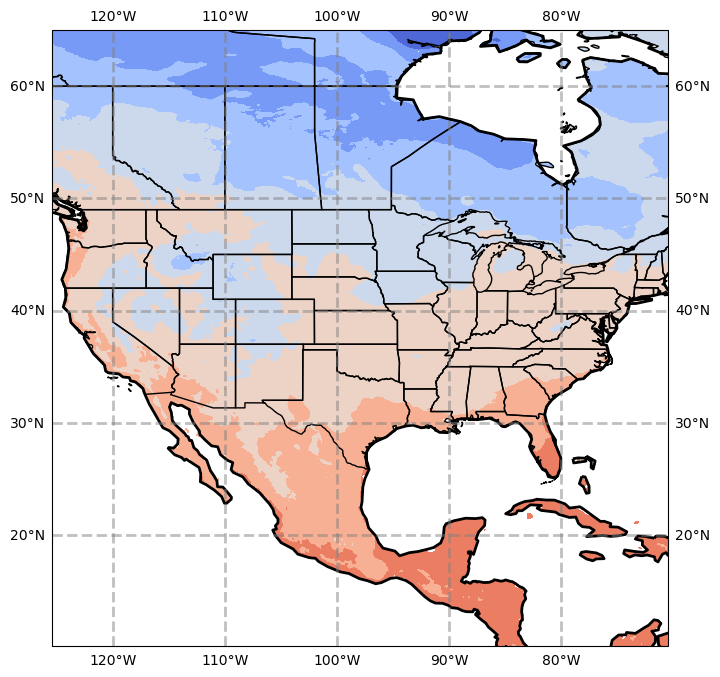

In [8]:
fig, ax = plt.subplots(figsize=(11, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines(linewidth=2)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

plt.contourf(lons, lats, temps.squeeze(), transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.add_feature(cfeature.STATES.with_scale('50m'), zorder=1, linewidth=1, edgecolor='black')